In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0,'/media/csivsw/crossOS/playground/friends_of_tracking/src/friends_of_tracking/LaurieOnTracking')
%matplotlib inline

import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import numpy as np
import matplotlib.pyplot as plt
import modin.pandas as pd
pd.options.display.max_columns = None

In [2]:
# set up initial path to data
DATADIR = '/media/csivsw/crossOS/playground/friends_of_tracking/datahub/metrica_sports/sample-data/data'
game_id = 2 # let's look at sample match 2

In [3]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)


Reading team: home
Reading team: away


## pitch control for passes leading up to goal 2

In [4]:
# get all shots and goals in the match
shots = events[events['Type']=='SHOT']
goals = shots[shots['Subtype'].str.contains('-GOAL')].copy()

goals

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,-47.70,1.36,-54.06,2.04
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,40.28,1.36,55.12,2.72
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,-30.74,5.44,-54.06,2.72


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f615c378630>)

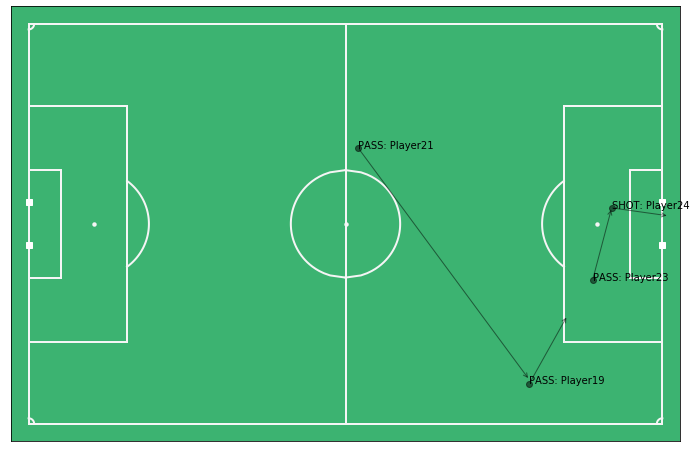

In [5]:
# plot the 3 events leading up to the second goal
mviz.plot_events( events.loc[820:823], color='k', indicators = ['Marker','Arrow'], annotate=True )

In [6]:
# first get model parameters
params = mpc.default_model_params(3)
params

{'max_player_accel': 7.0,
 'max_player_speed': 5.0,
 'reaction_time': 0.7,
 'tti_sigma': 0.45,
 'kappa_def': 1.0,
 'lambda_att': 4.3,
 'lambda_def': 4.3,
 'average_ball_speed': 15.0,
 'int_dt': 0.04,
 'max_int_time': 10,
 'model_converge_tol': 0.01,
 'time_to_control_att': 3.3202550055547313,
 'time_to_control_def': 3.3202550055547313}

Away


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f61183172b0>)

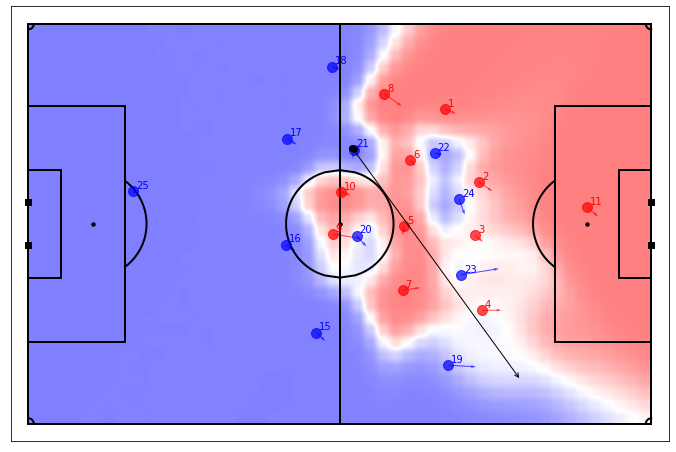

In [7]:
# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(820, events, tracking_home, tracking_away, 
                                                        params, field_dimen = (106.,68.,), 
                                                        n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 820, events,  tracking_home, tracking_away,
                                 PPCF, xgrid, ygrid, annotate=True )

Away


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f61184b0ef0>)

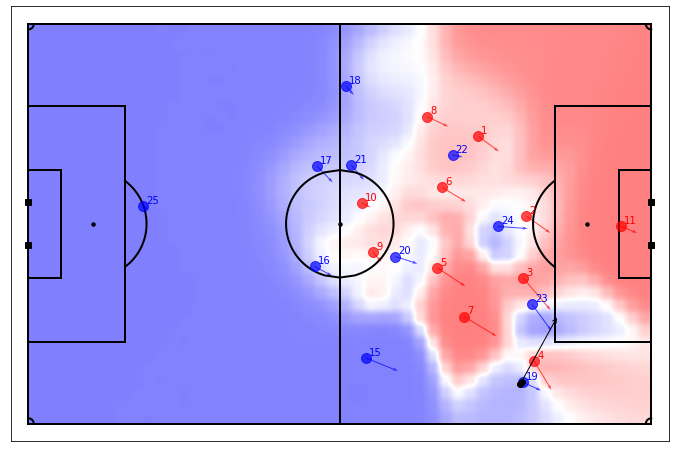

In [8]:
# evaluated pitch control surface for second pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(821, events, tracking_home, tracking_away, 
                                                        params, field_dimen = (106.,68.,), 
                                                        n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 821, events,  tracking_home, tracking_away, 
                                 PPCF, xgrid, ygrid, annotate=True )

Away


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f60f830ccf8>)

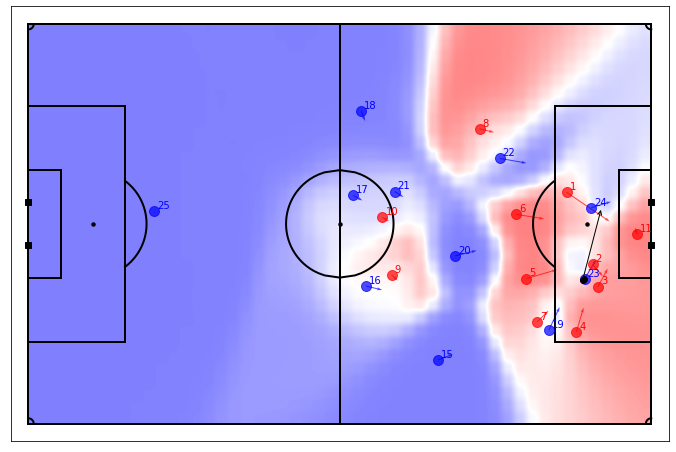

In [9]:
# evaluated pitch control surface for third pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(822, events, tracking_home, tracking_away, 
                                                        params, field_dimen = (106.,68.,), 
                                                        n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 822, events,  tracking_home, tracking_away, 
                                 PPCF, xgrid, ygrid, annotate=True )


## calculate pass probability for every home team succesful pass

In [10]:
# get all home passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]
home_passes.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
28,Home,PASS,NaN,1,1467,58.68,1489,59.56,Player1,Player11,46.64,21.08,53.00,10.20
29,Home,PASS,NaN,1,1489,59.56,1578,63.12,Player11,Player9,53.00,10.20,9.54,24.48
36,Home,PASS,HEAD,1,1672,66.88,1693,67.72,Player6,Player7,19.08,14.96,19.08,8.84
52,Home,PASS,NaN,1,2414,96.56,2440,97.60,Player3,Player8,16.96,-24.48,1.06,-29.92
53,Home,PASS,NaN,1,2465,98.60,2493,99.72,Player8,Player4,2.12,-29.92,10.60,-31.96


In [11]:
# list for storing pass probablities
pass_success_probability = []

for i,row in home_passes.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params)
    defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params)
    Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, 
                                                      attacking_players, 
                                                      defending_players, 
                                                      pass_start_pos, 
                                                      params)

    pass_success_probability.append( (i,Patt) )

pass_success_probability[:10]

[(28, 0.9761786746948964),
 (29, 0.31160841865474626),
 (36, 0.7518055328493832),
 (52, 0.6643544450943134),
 (53, 0.9336350554716212),
 (54, 0.9901257167861145),
 (55, 0.9714052407449258),
 (56, 0.9751056048813956),
 (57, 0.9836812077003456),
 (58, 0.5147228904616257)]

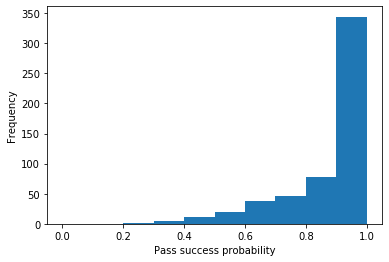

In [12]:
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability');
ax.set_ylabel('Frequency');

In [13]:
# sort the passes by pitch control probability
pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

In [14]:
# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1]<0.5 ] ]

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f60d877fc50>)

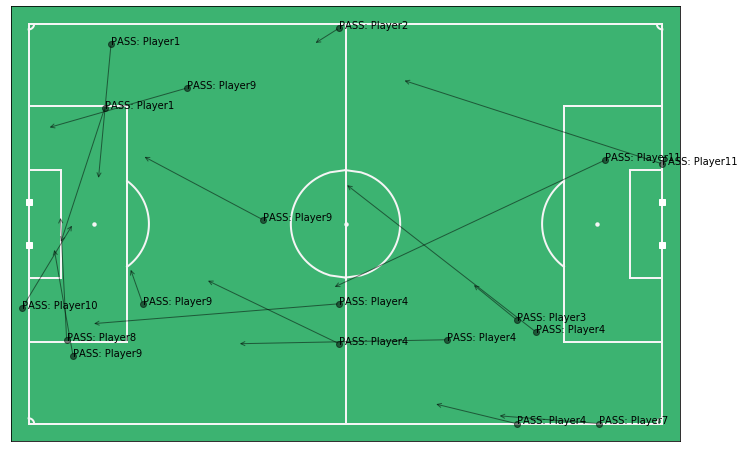

In [15]:
# plot the events
mviz.plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )

In [16]:
# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in pass_success_probability[:20]:
    outcome = events.loc[ p[0]+1 ].Type
    print( p[1], outcome )


Event following a risky (completed) pass
0.26455950351294005 CHALLENGE
0.28505234723760897 BALL LOST
0.3006628396711591 SHOT
0.31160841865474626 CHALLENGE
0.33704347298090714 CHALLENGE
0.3913125864694877 SHOT
0.4188148605128081 BALL LOST
0.4194468674048554 CHALLENGE
0.4204267746341931 PASS
0.4312712628523871 CHALLENGE
0.44436475742157466 CHALLENGE
0.44844895551994096 PASS
0.4593665151483775 CHALLENGE
0.4635633533167435 SHOT
0.468048170879984 CHALLENGE
0.4897275563912591 CHALLENGE
0.4900872646495704 CHALLENGE
0.4927699899300238 SHOT
0.5001349056944236 PASS
0.5026909720011078 PASS


In [17]:
events.tail()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,-4.24,18.36,22.26,-17.68
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,20.14,-13.60,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,19.08,-13.60,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,16.96,-12.24,NaN,NaN
1934,Home,BALL OUT,CLEARANCE,2,140265,5610.60,140298,5611.92,Player12,NaN,18.02,-23.12,9.54,-36.72


In [18]:
tracking_home.iloc[73600:73600+500].tail()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,Home_4_x,Home_4_y,Home_5_x,Home_5_y,Home_6_x,Home_6_y,Home_7_x,Home_7_y,Home_8_x,Home_8_y,Home_9_x,Home_9_y,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y,Home_1_vx,Home_1_vy,Home_1_speed,Home_10_vx,Home_10_vy,Home_10_speed,Home_11_vx,Home_11_vy,Home_11_speed,Home_12_vx,Home_12_vy,Home_12_speed,Home_13_vx,Home_13_vy,Home_13_speed,Home_14_vx,Home_14_vy,Home_14_speed,Home_2_vx,Home_2_vy,Home_2_speed,Home_3_vx,Home_3_vy,Home_3_speed,Home_4_vx,Home_4_vy,Home_4_speed,Home_5_vx,Home_5_vy,Home_5_speed,Home_6_vx,Home_6_vy,Home_6_speed,Home_7_vx,Home_7_vy,Home_7_speed,Home_8_vx,Home_8_vy,Home_8_speed,Home_9_vx,Home_9_vy,Home_9_speed
Frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
74096,2,2963.84,24.26446,-0.53992,-46.79158,13.62720,-14.76686,15.65224,-2.85140,-2.85056,-8.58918,-8.11036,-51.38032,9.84708,-33.65818,5.98740,-34.06946,-2.44460,-45.68070,-9.55808,-51.91032,14.65400,-47.66396,9.84980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.111857,4.388429,5.379773,-1.643000,5.532286,5.771103,-0.745786,0.366714,0.831069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.869000,1.559143,4.171341,-0.238500,1.850571,1.865877,-1.945857,2.292571,3.007032,-0.283929,5.291857,5.299469,-3.017214,3.485000,4.609643,-2.396357,3.295571,4.074717,-0.246071,3.599143,3.607545,0.310429,6.277857,6.285528
74097,2,2963.88,24.23584,-0.52700,-46.91454,13.80264,-14.92056,15.71752,-2.85988,-2.77644,-8.66868,-8.02400,-51.39304,10.05516,-33.77902,6.12816,-34.16380,-2.31268,-45.69236,-9.41596,-51.89442,14.91444,-47.72862,10.06944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.024786,4.458857,5.388018,-1.616500,5.529857,5.761284,-0.742000,0.391000,0.838716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.869000,1.571286,4.175895,-0.151429,1.889429,1.895487,-1.972357,2.326571,3.050103,-0.310429,5.240857,5.250043,-3.009643,3.519000,4.630476,-2.377429,3.344143,4.103103,-0.253643,3.599143,3.608069,0.355857,6.336143,6.346128
74098,2,2963.92,24.20616,-0.51068,-47.03326,13.98488,-15.07426,15.78144,-2.86094,-2.69756,-8.74924,-7.92880,-51.40470,10.26460,-33.89774,6.27028,-34.25708,-2.17804,-45.70190,-9.27248,-51.87958,15.16740,-47.79328,10.29044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.960429,4.502571,5.388626,-1.605143,5.510429,5.739452,-0.730643,0.415286,0.840417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.869000,1.561571,4.172250,-0.068143,1.930714,1.931916,-1.995071,2.360571,3.090729,-0.325571,5.206857,5.217026,-2.990714,3.548143,4.640441,-2.362286,3.375714,4.120175,-0.265000,3.601571,3.611307,0.389929,6.394429,6.406306
74099,2,2963.96,24.17648,-0.49096,-47.14562,14.17120,-15.23008,15.84536,-2.85882,-2.61732,-8.82980,-7.83020,-51.42060,10.47132,-34.01752,6.41036,-34.35036,-2.04068,-45.71568,-9.13308,-51.86050,15.42512,-47.85370,10.51144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.896071,4.543857,5.388308,-1.590000,5.491000,5.716571,-0.719286,0.439571,0.842968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.869000,1.576143,4.177725,0.018929,1.957429,1.957520,-2.017786,2.392143,3.129506,-0.352071,5.155857,5.167864,-2.975571,3.577286,4.653063,-2.347143,3.404857,4.135472,-0.257429,3.621000,3.630139,0.431571,6.469714,6.484093
74100,2,2964.00,24.14786,-0.47056,-47.25798,14.35412,-15.38484,15.90996,-2.85352,-2.53708,-8.91142,-7.73500,-51.43968,10.66920,-34.13518,6.55656,-34.44364,-1.90196,-45.72416,-8.98552,-51.84142,15.68420,-47.91624,10.73040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.820357,4.597286,5.393464,-1.567286,5.486143,5.705624,-0.711714,0.473571,0.854873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.876571,1.578571,4.185653,0.102214,1.979286,1.981923,-2.044286,2.389714,3.144811,-0.386143,5.087857,5.102489,-2.968000,3.587000,4.655705,-2.328214,3.455857,4.166957,-0.276357,3.625857,3.636374,0.469429,6.528000,6.544857


In [19]:
# Making a movie of the second home team goal
PLOTDIR = '/media/csivsw/crossOS/playground/friends_of_tracking/output/'
mviz.save_match_clip(tracking_home.iloc[73600:73600+500],
                     tracking_away.iloc[73600:73600+500],
                     PLOTDIR,fname='home_goal_2',include_player_velocities=False, 
                     params=params,events=events, pitch_control=True,attacking='Home')


  0%|          | 0/500 [00:00<?, ?it/s]

Generating movie...

100%|██████████| 500/500 [30:34<00:00,  3.67s/it]


done


In [ ]:
# from IPython.display import HTML

# HTML("""
#     <video alt="test" controls>
#         <source src="/media/csivsw/crossOS/playground/friends_of_tracking/output/home_goal_2.mp4" type="video/mp4">
#     </video>
# """)